## Plot hexagon modulation align EC mean orientation across 4-8 folds

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
data = pd.read_csv(r'/mnt/workdir/DCM/Result/Specificity_to_6/nilearn_cv/sub_stats-z_roi-ec_trial-even.csv')

In [18]:
# high performance filter
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
hp_info = participants_data.query(f'(game1_fmri>=0.5)and(game1_acc>0.8)')  # look out
hp_sub = hp_info['Participant_ID'].to_list()
data = data.loc[data['sub_id'].isin(hp_sub)]

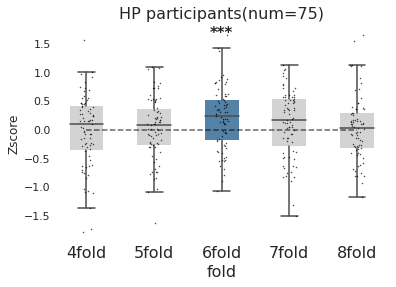

In [51]:
fig, ax = plt.subplots()
sns.boxplot(x='ifold', y="statistic", data=data, width=.5,
            palette=["lightgray", "lightgray", "steelblue", "lightgray", "lightgray"],
            boxprops={'edgecolor':'None'},showfliers=False
            )
sns.stripplot(x='ifold', y="statistic", data=data, size=1.5, color='.01', linewidth=0,alpha=0.7)
ax.tick_params(axis='both', length=0)
x = [0,1,2,3,4]
y = [0]*len(x)
plt.plot(x, y, linestyle='--', color='black',alpha=0.6)
plt.xticks(size=16)
plt.xlabel('fold',size=16)
plt.ylabel('Zscore')
# remove the box lines of the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add asterisks on top of each bar
vmean = np.max(data['ifold']=='6fold')
ax.text(2, vmean+0.55, '***',ha='center', va='bottom',weight='bold',size=15)

sub_num = len(set(data['sub_id']))
plt.title("HP participants(num={})".format(sub_num),size=16)
plt.savefig(r'/mnt/workdir/DCM/Result/Specificity_to_6/nilearn_cv/Specificity_to_6fold.svg',bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()

In [16]:
from scipy.stats import ttest_1samp
ifold_p = []
for i in range(4,9):
    ifold = str(i)+'fold'
    fold6_act = data[data['ifold']==ifold]['statistic'].to_list()
    _,p = ttest_1samp(fold6_act,0,alternative='greater')
    ifold_p.append(p)
    p = round(p,5)
    print('one sample t-test for {}fold: pvalue={}'.format(i,str(p).zfill(3)))

one sample t-test for 4fold: pvalue=0.63654
one sample t-test for 5fold: pvalue=0.34249
one sample t-test for 6fold: pvalue=0.00102
one sample t-test for 7fold: pvalue=0.0588
one sample t-test for 8fold: pvalue=0.30387


In [76]:
from scipy.stats import ttest_rel

act1 = data[data['ifold']=="6fold"]['statistic'].to_list()
act2 = data[data['ifold']=="5fold"]['statistic'].to_list()
_,p = ttest_rel(act1,act2)
p = round(p,6)
print('pair t-test result: pvalue={}'.format(p))

pair t-test result: pvalue=0.565933
